# Классифицакия токсичных комментариев

Импорт всех необходимых библиотек:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Для обучения классификатора был использован набор данных с платформы Kaggle "Russian language toxic comments", который был сформирован на основе токсичных комментариев в сайта 2ch.hk и pikabu.ru.

In [2]:
df = pd.read_csv('labeled.csv', sep=',')

In [3]:
df.shape

(14412, 2)

In [4]:
df.dtypes

comment     object
toxic      float64
dtype: object

In [5]:
df['toxic'] = df['toxic'].apply(int)

In [6]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [7]:
df['toxic'].value_counts(normalize=True)

0    0.665071
1    0.334929
Name: toxic, dtype: float64

In [8]:
for i in df[df['toxic']==1]['comment'].head(5):
    print(i)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [9]:
for i in df[df['toxic']==0]['comment'].head(5):
    print(i)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [10]:
train_df, test_df = train_test_split(df,test_size=500)

In [11]:
test_df.shape

(500, 2)

In [12]:
test_df['toxic'].value_counts()

0    352
1    148
Name: toxic, dtype: int64

## Предобработка текста

In [13]:
#Предобработка текста (text preprocessing) для одного объекта
sentence_example = df.iloc[1]["comment"]
#Разделение предложения на токены
tokens = word_tokenize(sentence_example, language='russian')
#Токены без пунктуации
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
#Стоп-слова на рускком языке
russian_stop_words = stopwords.words('russian')
#Токены без стоп-слов и пунктуации
tokens_without_stopwords_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
#Стеммер
snowball = SnowballStemmer(language = 'russian')
#Применение стемминга
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stopwords_and_punctuation]

In [14]:
print(f"Исходный текст: {sentence_example}")
print("-----------------------------")
print(f"Токены:  {tokens}")
print("-----------------------------")
print(f"Токены без пунктуации: {tokens_without_punctuation}")
print("-----------------------------")
print(f"Токены без пунктуации и стоп-слов: {tokens_without_stopwords_and_punctuation}")
print("-----------------------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("-----------------------------")

Исходный текст: Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

-----------------------------
Токены:  ['Хохлы', ',', 'это', 'отдушина', 'затюканого', 'россиянина', ',', 'мол', ',', 'вон', ',', 'а', 'у', 'хохлов', 'еще', 'хуже', '.', 'Если', 'бы', 'хохлов', 'не', 'было', ',', 'кисель', 'их', 'бы', 'придумал', '.']
-----------------------------
Токены без пунктуации: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'а', 'у', 'хохлов', 'еще', 'хуже', 'Если', 'бы', 'хохлов', 'не', 'было', 'кисель', 'их', 'бы', 'придумал']
-----------------------------
Токены без пунктуации и стоп-слов: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'хохлов', 'хуже', 'Если', 'хохлов', 'кисель', 'придумал']
-----------------------------
Токены после стемминга: ['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'хохл', 'кисел', 'придума']
-----------------

In [15]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [16]:
tokenize_sentence(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [17]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x,remove_stop_words = True))

In [18]:
features = vectorizer.fit_transform(train_df["comment"])

## Обучение модели

In [19]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df["toxic"])

LogisticRegression(random_state=0)

In [20]:
model.predict(features[0])

array([0], dtype=int64)

In [21]:
train_df["comment"].iloc[0]

'Пойду узнаю как оформить визу\n'

In [22]:
model_pipeline = Pipeline([
    ("vectorizer",TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x,remove_stop_words = True))),
    ("model",LogisticRegression(random_state=0))
]
)

In [23]:
model_pipeline.fit(train_df["comment"], train_df["toxic"])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000019AF703A820>)),
                ('model', LogisticRegression(random_state=0))])

In [24]:
model_pipeline.predict(["Всем привет! Мне очень понравился этот пост!"])

array([0], dtype=int64)

In [25]:
model_pipeline.predict(["Слушай, а не пойти бы тебе нафиг отсюда?"])

array([1], dtype=int64)

### Расчет метрик precison и recall

In [26]:
precision_score(y_true = test_df["toxic"], y_pred = model_pipeline.predict(test_df["comment"]))

0.8611111111111112

In [27]:
recall_score(y_true = test_df["toxic"], y_pred = model_pipeline.predict(test_df["comment"]))

0.6283783783783784

In [29]:
prec, rec, thresholds = precision_recall_curve(y_true = test_df["toxic"], probas_pred = model_pipeline.predict_proba(test_df["comment"])[:,1])

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


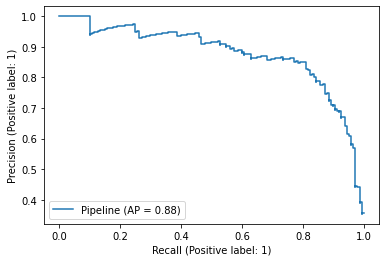

In [30]:
plot_precision_recall_curve(estimator=model_pipeline,X=test_df["comment"], y=test_df["toxic"])